In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [6]:
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input
from tensorflow.keras import Model
from tqdm import tqdm

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input
from tensorflow.keras import Model
from tqdm import tqdm

In [7]:
env = gym.make("MsPacman-v0")

In [8]:
s = env.reset()

## Observing the environment

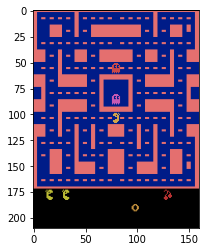

In [9]:
plt.imshow(s)

##### Image preprocessing accord to the original paper

In the original DQN paper (http://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), the authors take the raw <210x160x3> tensor, make it grayscale <210x160x1> and downsample to <110x84x1>. Finally, they crop it down to <84x84x1>.

$\phi(s)$ takes in the last 4 frames of a history and stacks them to produce the Q-function input. The GYM version of the Atari environments does not allow for this to be possible. See this discussion for more information: https://github.com/openai/gym/issues/275

NOTE: I make the dimensions slightly larger (90x90), as the original size seems to cut off the lowest hallway in this specific game

In [10]:
def phi(frame):
    """Expects type batch of tensors (already normed)"""
    # (1) Grayscale
    frame = tf.image.rgb_to_grayscale(frame)
    
    # (2) Downsample
    frame = tf.image.resize(frame, size=[110, 90])
    
    # (3) Crop only the relevant portion
    return frame[:, :90,:]

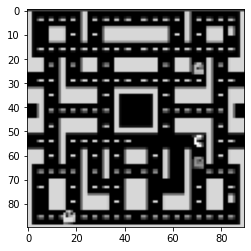

In [49]:
example_state = phi(tf.convert_to_tensor([s / 255.]))
plt.imshow(tf.squeeze(example_state[0]), cmap='gray')

## Replay Memory

In the original paper, the replay memory samples randomly (uniform) over the experience tuples in the memory. The authors state: "this approach is in some respects limitedsince  the  memory  buffer  does  not  differentiate  important  transitions  and  always  overwrites  withrecent transitions due to the finite memory size N"

To overcome this issue, I have also implemented Prioritized Experience Replay (PER) (https://arxiv.org/pdf/1511.05952.pdf)

In [12]:
INPUT_DIMS = (90, 90, 1)

In [13]:
class ReplayMemory:
    def __init__(self, input_dims, mem_size):
        self.mem_size = mem_size
        self.state_mem = np.zeros((self.mem_size, *input_dims))
        self.action_mem = np.zeros(self.mem_size, dtype=np.int)
        self.reward_mem = np.zeros(self.mem_size)
        self.state_mem_ = np.zeros((self.mem_size, *input_dims))
        self.terminal_mem = np.zeros(self.mem_size)
        
        self.mem_cntr = 0
        
    def remember(self, state, action, reward, state_, done):
        idx = self.mem_cntr % self.mem_size
        
        self.state_mem[idx] = state
        self.action_mem[idx] = action
        self.reward_mem[idx] = reward
        self.state_mem_[idx] = state_
        self.terminal_mem[idx] = 1 - int(done)  # done == 1 in OpenAI Gym
        self.mem_cntr += 1
    
    def sample(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_mem[batch]
        actions = self.action_mem[batch]
        rewards = self.reward_mem[batch]
        states_ = self.state_mem_[batch]
        dones = self.terminal_mem[batch]
        return states, actions, rewards, states_, dones

## Model

One key difference between this implementation and the original paper:

In the paper, they stack four consecutive frames $[x_{t-3}, ..., x_{t}]$. In the OpenAI Gym environment, a given action is performed over $k \sim U(2,4)$ frames, so this is not necessary.

__Objective function and gradient:__

$$
\mathcal{L}_i(\theta_i) = \mathbb{E}_{s,a \sim \rho(\cdot)}[(y_i - Q(s,a;\theta_i))^2] \\
y_i = \mathbb{E}_{s^{\prime}\sim \mathcal{E}}[r_i + \gamma \max_{a^{\prime}} Q(s^{\prime}, a^{\prime}; \theta_{i-N})] \\
\nabla_{\theta_i} \mathcal{L}_i(\theta_i) = \mathbb{E}_{s,a\sim \rho(\cdot), s^{\prime}\sim \mathcal{E}}[(r + \gamma \max_{a^{\prime}} Q(s^{\prime}, a^{\prime}; \theta_{i-N}) - Q(s,a;\theta_i))\nabla_{\theta_i}Q(s,a,;\theta_i)]
$$

note that the TD target uses a lagged-version of the Q-network, $Q(\cdot;\theta_{i-N})$. The original authors use this to add some stability to the training process.

In [14]:
class DQN(Model):
    def __init__(self, input_shape):
        super(DQN, self).__init__()
        self.conv1 = Conv2D(input_shape=input_shape, filters=16, 
                            kernel_size=(8, 8), strides=4, activation='relu',
                            padding='same')
        self.conv2 = Conv2D(filters=32, kernel_size=(4, 4), 
                            strides=2, activation='relu', padding='same')
        self.flat = Flatten()
        self.d1 = Dense(256, activation='relu')
        self.out = Dense(9, activation='linear')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flat(x)
        x = self.d1(x)
        return self.out(x)

## Agent

In [15]:
class DQNAgent:
    def __init__(self, q_network, target_q_network, replay_memory,
                 epsilon, phi, example_state, loss_fn, optimizer,
                 gamma, batch_size, n_actions, model_folder):
        
        self.pi = q_network
        self.pi_target = target_q_network
        self.memory = replay_memory
        self.epsilon = epsilon
        self.phi = phi
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.model_folder = model_folder
        
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        self._safe_start(example_state=example_state)
        
    def _safe_start(self, example_state):
        """In order to copy weights from one sub-classed model to another,
            the weights need to be initialized.
            In order for weights of a sub-classed model to be initialized,
            we need to run data through the network.
        """
        self.pi(example_state)
        self.pi_target(example_state)
        self.pi_target.set_weights(self.pi.get_weights())
        
    def copy_weights(self):
        self.pi_target.set_weights(self.pi.get_weights())
    
    def choose_action(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            # NotFoundError: No algorithm worked! [Op:Conv2D]
            # For some reasons, self.phi() sometimes fails to convert?
            model_input = self.phi(tf.convert_to_tensor([s]))
            return np.argmax(self.pi(model_input))
        
    def remember(self, s, a, r, s_, d):
        s = self.phi(tf.convert_to_tensor([s]))
        s_ = self.phi(tf.convert_to_tensor([s_]))
        self.memory.remember(s, a, r, s_, d)
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        s, a, r, s_, d = self.memory.sample(self.batch_size)
        
        q_state = self.pi(s)
        q_state_ = self.pi_target(s_)
        
        q_target = np.copy(q_state)
        batch_idx = np.arange(self.batch_size)
        
        q_target[batch_idx, a] = r + self.gamma * np.max(q_state_, axis=1) * d
        
        self._train(X=s, y=q_target)
        
        
    @tf.function
    def _train(self, X, y):
        with tf.GradientTape() as tape:
            preds = self.pi(X)
            loss = self.loss_fn(preds, y)
        gradient = tape.gradient(loss, self.pi.trainable_variables)
        self.optimizer.apply_gradients(zip(gradient, self.pi.trainable_variables))
        

## Training loop

In [16]:
mem = ReplayMemory(input_dims=INPUT_DIMS, mem_size=10000)
Q_pi = DQN(input_shape=INPUT_DIMS)
Q_target = DQN(input_shape=INPUT_DIMS)

# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00025)
optimizer = tf.keras.optimizers.Adam()

agent = DQNAgent(q_network=Q_pi, target_q_network=Q_target, 
                 replay_memory=mem, epsilon=0.99, phi=phi, 
                 example_state=example_state, 
                 loss_fn=tf.keras.losses.MeanSquaredError(), 
                 optimizer=optimizer, gamma=0.99, 
                 batch_size=128, n_actions=9, model_folder='./results/')

# To load weights between sessions
# agent.pi.load_weights('./results/pi/')
# agent.pi_target.load_weights('./results/pi_target/')

Here, we prefill the replay memory with experiences.

In [ ]:
scores = []
n_games = 1000
exploration_episodes = 5

for i in tqdm(range(exploration_episodes)):
    d = False
    s = env.reset() / 255.
    while not d:
        a = np.random.choice(9)
        s_, r, d, _ = env.step(a)
        s_ = s_ / 255.
        agent.remember(s, a, r, s_, d)
        s = s_


# for i in tqdm(range(n_games)):
for i in range(n_games):
    d = False
    score = 0
    s = env.reset() / 255.
    while not d:
        a = agent.choose_action(s)
        s_, r, d, _ = env.step(a)
        s_ = s_ / 255.
        score += r
        agent.remember(s, a, r, s_, d)
        agent.learn()
        s = s_
    scores.append(score)
    agent.copy_weights()
    agent.epsilon *= 0.994
    if agent.epsilon < 0.1:
        agent.epsilon = 0.1
    print(f'Ep: {i}, Avg score: {np.mean(scores[i-100:])}')
    if (i+1) % 100 == 0:
        os.mkdir(f'./results/{i}')
        agent.pi.save_weights(f'./results/{i}/pi/')
        agent.pi_target.save_weights(f'./results/{i}/pi_target/')

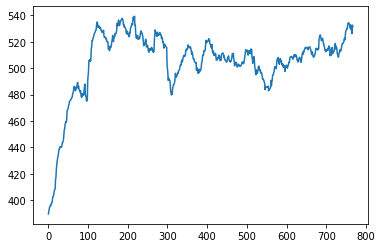

In [42]:
b_idx = 0
e_idx = 200
smoothed_scores2 = []
while e_idx <= len(scores[:]):
    smoothed_scores2.append(np.mean(scores[b_idx: e_idx]))
    b_idx += 1
    e_idx += 1
    
plt.plot(smoothed_scores2)